In [1]:
from modular_entanglement import *
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import time
%matplotlib inline

This notebook is intended to provide all the necessary code to duplicate the results in Section V of "Unitary Entanglement Construction in Hierarchical Networks," Bapat et al 2018. All functions called are stored in a file called modular_entanglement.py, which should have been distributed with this notebook. Contact Zachary Eldredge at eldredge@umd.edu with questions.

This code is intended to perform circuit placement on a large number of randomly generated circuits, placing them onto hierarchy graphs. The first section demonstrates how circuit placement is performed on a single graph, before moving on to more profiling-based work.

# Circuit Placement Demonstration

Before the code that performs many trials to profile the average performance of our circuit placement, I'd like to demonstrate how the circuit placement function is used, so it can be understood without all the iteration. Here is how it works. First, we build a hierarchy graph (with all edges unity weight, i.e., $\alpha = 1$). We'll build $K_3^{\Pi 4}$. 

In [2]:
hierarchy = build_weighted_hierarchical(nx.complete_graph(3), 4, lambda x: 1)

Now, we need a circuit to place. We'll use the function $\mathrm{get\_random\_comp\_graph}$ to produce a computational graph that has random edges. We'll say it has 1000 gates placed on it (that ends up being the total edge weight, added one at a time between random nodes).

In [3]:
comp = get_random_comp_graph(3**4, 100)

How bad is this circuit right now? We can first look at the "default" mapping where we just naively match nodes in comp to nodes in hierarchy. Then we evaluate the cost with $\mathrm{length\_cost}$, which needs the computational graph, the metric, and the mapping between them. That mapping needs to be a one-to-one dictionary in which the keys are node labels in the metric graph and the values are node labels in the computational graph (in this case, just integers).

In [4]:
#Blindly take the hierarchy nodes and set them to the computational graph
#Note that it doesn't really matter how we do this since comp_graph is random
naive_map = {j:i for i, j in enumerate(hierarchy.nodes())} 

#Now, we count the total length the gates in comp must traverse in this mapping
init_cost = length_cost(comp, hierarchy, naive_map)
print('Initial cost = {}'.format(init_cost))

Initial cost = 430


Now, we want to perform partition-and-rotate. This is accomplished by the function $\mathrm{pr\_split\_nodes}$, which is a recursive function that first splits all the nodes into small clusters and then re-assembles those clusters (and clusters of clusters etc) in the correct order, "rotating" to ensure that the best node is always at the root of each hierarchy. It returns a list in which the $i$th element represents the $i$th sub-hierarchy, and so on, recursively.

In [5]:
pr_list = pr_split_nodes(comp, comp.nodes(), 3)
pr_list

[[[[73, 56, 79], [23, 3, 63], [70, 0, 30]],
  [[10, 9, 20], [17, 36, 57], [24, 60, 40]],
  [[49, 11, 26], [29, 38, 16], [39, 21, 31]]],
 [[[15, 33, 2], [7, 47, 14], [5, 80, 76]],
  [[62, 52, 46], [4, 27, 44], [41, 48, 51]],
  [[25, 6, 64], [19, 50, 34], [66, 61, 69]]],
 [[[58, 74, 32], [43, 54, 35], [1, 53, 71]],
  [[22, 45, 68], [13, 59, 75], [65, 12, 67]],
  [[37, 77, 42], [28, 72, 78], [18, 55, 8]]]]

I find this list very elegant but also totally impossible to work with further in the program sadly. Don't worry -- we have a function ($\mathrm{convert\_split\_list\_to\_dict}$) that takes this list and turns it into a mapping dictionary you can actually work with. Now we'll use $\mathrm{length\_cost}$ again to see the circuit cost under this new mapping.

In [6]:
pr_dict = convert_split_list_to_dict(pr_list)
final_cost = length_cost(comp, hierarchy, pr_dict)
print('Final cost = {}'.format(final_cost))
print('This is a {0:.2%} reduction from the initial cost.'.format(1 - final_cost/init_cost))

Final cost = 183
This is a 57.44% reduction from the initial cost.


# Profiling the Performance

Now that you've seen it work once (and hopefully see how to use it yourself if you like) we will do it many times to demonstrate the algorithm's performance statistically. The following loop runs over $K_3^{\Pi i}$ for several $i$ declared in $\mathrm{levels\_list}$. On each hierarchy it places random computational graphs of different numbers of gates, specified in $\mathrm{ngates\_list}$. For each of these pairs, it runs $\mathrm{ntrials}$ iterations of:

1) Create random computational graph

2) Evaluate the initial cost using the "naive" mapping

3) Perform parition-and-rotate

4) Re-evaluate the cost with the optimized mapping

We also time each iteration. All of these trials are stored in a Pandas dataframe. Note that the default parameters should run in less than five minutes.

## Test Parameters

In [7]:
levels_list = [2,3,4,5,6]
ngate_list = [10,30,100,300,1000]
ntrials = 10
base_graph = nx.complete_graph(3)
base_order = len(base_graph)

## Test Loop

In [8]:
%%time
nqubits_list = [base_order**i for i in levels_list] # A list of how many qubits are included in each test circuit

#Build the empty dataframe and initiate a counter
column_list = ['NQubits', 'NGates', 'P+R Time (s)', 'Initial Cost', 'Final Cost']
full_df = pd.DataFrame([], columns= column_list)
iterate_counter = 0

for nqubits in nqubits_list: # Loop over qubit sizes
    hierarchy = build_weighted_hierarchical(base_graph, ceil(log(nqubits,base_order)), lambda x: 1)
    for ngates in ngate_list: # Loop over number of gates
        for trial in range(ntrials): # Loop over every trial
            c = get_random_comp_graph(nqubits, ngates) # Get a random computational graph
            
            init_cost = length_cost(c, hierarchy, {j:i for i,j in enumerate(hierarchy.nodes())}) # Calculate "naive" cost
            
            start = time.time() # Start timing 
            pr_split_list = pr_split_nodes(c, c.nodes(), base_order) # Run partition-and-rotate
            pr_dict = convert_split_list_to_dict(pr_split_list) # Conver to a mapping
            end = time.time()
            
            pr_cost = length_cost(c, hierarchy, pr_dict) # Get cost under new mapping
            pr_time = end - start # Calculate how long that took
            
            trial_df = pd.DataFrame([[nqubits, ngates, pr_time, init_cost, 
                                      pr_cost]],
                               columns=column_list, 
                                    index = [iterate_counter]) # Create a dataframe for this trial
            iterate_counter += 1 # Iterate the counter
            full_df = full_df.append(trial_df) # Add this trial to the running data frame

            
# All trials are done -- some post-processing
full_df['Initial Cost'] = full_df['Initial Cost'].astype(int) # Case some stuff to floats
full_df['Final Cost'] = full_df['Final Cost'].astype(int)
full_df['Ratio'] = full_df['Final Cost']/full_df['Initial Cost'] # Compute the ratio that describes the improvement

CPU times: user 19.8 s, sys: 9.95 s, total: 29.8 s
Wall time: 3min 16s


At this point, the DataFrame $\mathrm{full\_df}$ contains the individual statistics for every single separate "experiment." This isn't that useful, so we use $\mathrm{pandas.groupby().mean()}$ and $\mathrm{pandas.groupby().std()}$ to find the mean and standard deviation of the trials, grouped by the number of qubits and the number of gates. The standard deviations in $\mathrm{std_df}$ are used for plotting later.

In [9]:
mean_df = full_df.groupby(['NQubits','NGates']).mean() # New dataframe with average values
std_df = full_df.groupby(['NQubits','NGates']).std() # New dataframe with standard deviations
mean_df # Just to print the averages

P+R Time (s)  Initial Cost  Final Cost     Ratio
NQubits NGates                                                  
9       10          0.036085          19.0        12.3  0.652525
        30          0.030568          61.0        47.5  0.779889
        100         0.041902         200.4       174.2  0.871286
        300         0.034056         596.8       556.6  0.932822
        1000        0.027569        1997.3      1924.7  0.963897
27      10          0.100206          32.5        10.4  0.322724
        30          0.117472          95.4        45.1  0.476408
        100         0.127163         313.6       224.2  0.715870
        300         0.115269         935.1       803.4  0.859693
        1000        0.113754        3133.5      2901.1  0.925929
81      10          0.291510          44.6        10.0  0.226340
        30          0.445824         137.3        32.2  0.235613
        100         0.324857         441.7       183.8  0.417075
        300         0.429134        1326.7       909.6  0.685805
        1000        0.418155        4420.9      3697.9  0.836572
243     10          0.521880          56.8        10.0  0.176990
        30          0.888472         173.5        30.0  0.173350
        100         1.094221         570.9       108.5  0.190250
        300         1.135477        1707.0       647.6  0.379445
        1000        1.316917        5689.3      3924.5  0.689917
729     10          0.996298          72.7        10.0  0.138113
        30          1.598102         208.8        30.0  0.143990
        100         2.424564         698.9       100.8  0.144303
        300         2.981897        2110.2       326.1  0.154552
        1000        3.393890        7024.4      2708.0  0.385558

## Visualization

Now we're just going to make some plots that compare the different performances. The first shows the performance, in terms of the ratio of initial to final costs, and how that scales as gates are added.

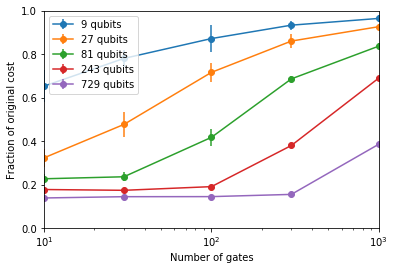

In [10]:
for i in nqubits_list:
    mean_df.loc[i]['Ratio'].plot(yerr = std_df.loc[i]['Ratio'],
        marker='o', ax=plt.gca(), legend = False, logx = True, logy = False, label = str(i) + ' qubits')
plt.ylim(0,1)
plt.xlabel('Number of gates')
plt.ylabel('Fraction of original cost')
plt.legend(["{} qubits".format(i) for i in nqubits_list])

This next plot shows the runtime of the program for various numbers of gates as we increase the size of the circuit.

In [11]:
for i in ngate_list:
    plt.loglog(nqubits_list,mean_df.xs(i,level='NGates')['P+R Time'], marker = 'o', label = str(i) + ' gates')
plt.ylabel('Run time of program (s)')
plt.xlabel('Number of qubits')
plt.legend()

KeyError: 'P+R Time'

Finally, program runtime where we look at lines of constant numbers of qubits as the number of gates scales.

In [ ]:
for i in nqubits_list:
    plt.loglog(ngate_list,mean_df.xs(i,level='NQubits')['P+R Time'], marker = 'o', label = str(i) + ' qubits')
plt.ylabel('Run time of program (s)')
plt.xlabel('Number of gates')
plt.legend(loc = 2)